In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.utils.testing import ignore_warnings
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [12]:
with open('data.pickle','rb') as file: 
    dataTrain,dataTest = pickle.load(file)
    
Xtrain,Ttrain = dataTrain 
Xtest,Ttest = dataTest

# Data Visualization

In [13]:
def plot_clusters(X, R, Mu):
    '''
    Displays the data points in X and the clusters defined by R and Mu

    Parameters
    ----------
    X : data matrix 
    R : responsability matrix
    Mu : cluster means

    Returns
    -------
    None.

    '''
    # Adding up responsabilities and sorting in ascending order
    sum_R = R.sum(axis=0)
    sort_indices = np.argsort(sum_R)
    sorted_R = R[:, sort_indices]

    # Plotting
    plt.scatter(X[:, 0], X[:, 1], color=sorted_R, s=5)
    plt.scatter(Mu[:, 0], Mu[:, 1], color="black")

# Exploring KMeans

## Using sklearn 

In [14]:
# Defining and fitting KMeans using sklearn
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters).fit(Xtrain)

In [15]:
print("K-means objective function on the training data =", kmeans.score(Xtrain))
test_score_sk = kmeans.score(Xtest)
print("K-means objective function on the test data =", test_score_sk)

K-means objective function on the training data = -3536.424192018344
K-means objective function on the test data = -3732.251470247857


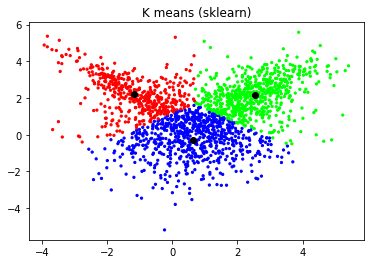

In [16]:
# Finding Kmeans predictions
preds = kmeans.predict(Xtrain)

# Creating a one hot encoding for the predictions to use as R
one_hot = np.zeros((len(preds), n_clusters))
row_indices = np.arange(len(preds))
one_hot[row_indices, preds] = 1

# Plotting
plt.title("K means (sklearn)")
plot_clusters(Xtrain, one_hot, kmeans.cluster_centers_)

## My implementation 

In [17]:
def myKmeans(X,K,I):
    '''
    Searches for K clusters in data matrix X by performing I iterations 
    of the (hard) K-means algorithm

    Parameters
    ----------
    X : data matrix
    K : number of clusters
    I : number of iterations

    Returns
    -------
    Mu : cluster centers
    R : one-hot encoding of assignments
    scores : list of computed scores

    '''
    N, D = X.shape
    
    # Randomly initializing cluster centers with dimension K, D
    # The range to choose from is from the smallest to largest value
    # in the dataset to make sure they are spread around.
    Mu = np.random.uniform(np.min(X),np.max(X),[K,D])
    R = np.zeros((N, K))
    scores = []
    
    for i in range(I):
        
        # Assignment step
        A = np.reshape(X,[N, 1, D])
        B = np.reshape(Mu,[1, K, D])
        square_diff = (A - B)**2
        square_diff = square_diff.sum(axis=2)
        
        # Saving the value of the score for this iteration
        scores.append(np.amin(square_diff, axis=1).sum())
        
        # Finding the class predictions
        k_hat = np.argmin(square_diff, axis=1)
        
        # Finding responsibility vector
        R = np.zeros((N, K))
        row_indices = np.arange(len(k_hat))
        R[row_indices, k_hat] = 1
        
        # Refitting
        Nk = np.sum(R, axis=0)
        Mu = (R.T @ X)/Nk.reshape(Nk.shape[0], 1)
    
    return Mu, R, scores

def scoreKmeans(X,Mu):
    '''
    Computes and returns the score of clusters defined by Mu 
    on data matrix X

    Parameters
    ----------
    X : data matrix
    Mu : cluster centers

    Returns
    -------
    score of Kmeans objective function

    '''
    N, D = X.shape
    A = np.reshape(X,[N, 1, D])
    B = np.reshape(Mu,[1, Mu.shape[0], D])
    square_diff = (A - B)**2
    square_diff = square_diff.sum(axis=2)
    return np.amin(square_diff, axis=1).sum()

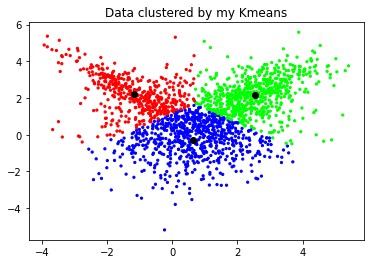

In [18]:
# Finding and plotting clusters
Mu, R, scores = myKmeans(Xtrain,3,100)
plt.title("Data clustered by my Kmeans")
plot_clusters(Xtrain,R,Mu)

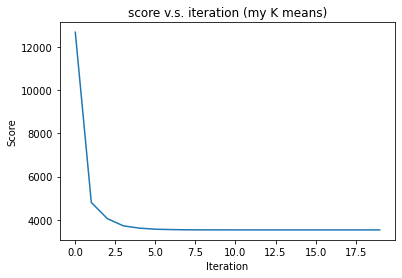

In [19]:
plt.title("score v.s. iteration (my K means)")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.plot(range(20), scores[:20])

#### We can see that the score decreases and eventually converges 

In [22]:
score_train = scoreKmeans(Xtrain, Mu)
score_test = scoreKmeans(Xtest, Mu)
print("myKmeans train score =", score_train)    
print("myKmeans test score =", score_test)
print("Difference between myKmeans and sklearn =", score_test + test_score_sk)  

myKmeans train score = 3536.450268199036
myKmeans test score = 3730.6655179668096
Difference between myKmeans and sklearn = -1.5859522810474118


# Exploring GMMs

## Using sklearn 

In [24]:
# Defining and fitting Gaussian mixture model (spherical)
gmm = GaussianMixture(n_components=n_clusters, covariance_type='spherical')
gmm.fit(Xtrain)

# Finding prediction probabilities
R = gmm.predict_proba(Xtrain)

# Printing scores
print("GMM objective function on the training data =", gmm.score(Xtrain))
test_score_sph = gmm.score(Xtest)
print("GMM objective function on the test data =", test_score_sph)

GMM objective function on the training data = -3.6947667386861394
GMM objective function on the test data = -3.7611063198462107


Text(0.5, 1.0, 'Gaussian mixture model (spherical)')

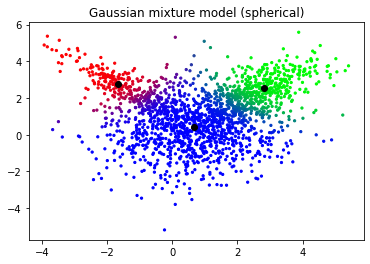

In [28]:
# Data clusters using sklearn's 'spherical' covariance
plot_clusters(Xtrain, R, gmm.means_)
plt.title("Gaussian mixture model (spherical)")

In [30]:
# Defining and fitting Gaussian mixture model (full)
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
gmm.fit(Xtrain)

# Finding prediction probabilities
R = gmm.predict_proba(Xtrain)

# Printing scores
print("GMM objective function on the training data =", gmm.score(Xtrain))
test_score_full = gmm.score(Xtest)
print("GMM objective function on the test data =", test_score_full)
print("Difference between full and spherical test scores =", test_score_full - test_score_sph)

GMM objective function on the training data = -3.594361136392263
GMM objective function on the test data = -3.729783366732916
Difference between full and spherical test scores = 0.031322953113294805


Text(0.5, 1.0, 'Question 4(d): Gaussian mixture model (full)')

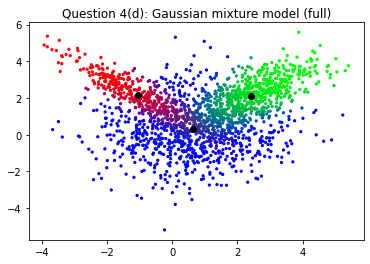

In [32]:
# Data clusters using sklearn's 'full' covariance
plot_clusters(Xtrain, R, gmm.means_)
plt.title("Gaussian mixture model (full)")

## My implementation 

In [37]:
def myGMM(X,K,I):
    '''
    Searches for K clusters in data matrix X by performing I iterations of 
    the EM algorithm for Gaussian mixture models.
    Equivalent to sklearn's 'spherical' covariance type
    
    Parameters
    ----------
    X : data matrix
    K : number of clusters
    I : number of iterations

    Returns
    -------
    Mu : cluster centers
    R : one-hot encoding of assignments
    Pi : mixing proportions
    scores : list of computed scores

    '''
    N, D = X.shape
    Pi = np.ones((K,)) * 1/K
    Mu = np.random.uniform(np.min(X),np.max(X),[K,D])
    scores = []
    
    for i in range(I):
        
        # Broadcasting to avoid use of loops
        Xs = np.reshape(X, [N, 1, D])
        means = np.reshape(Mu, [1, K, D])
        
        # Expectation Step
        X_minus_mu = (Xs - means)**2
        likelihood = Pi * np.exp((-1/2) * np.sum(X_minus_mu, axis=2))
        total = likelihood.sum(axis=1)
        
        # Computing mean log likelihood
        mean_log = np.log(total / (2*np.pi)**(D/2)).mean()
        scores.append(mean_log)
        
        # Computing responsabilities
        R = likelihood / total.reshape(total.shape[0], 1)
        
        # Refitting
        Nk = np.sum(R, axis=0)
        Mu = (R.T @ X)/Nk.reshape(Nk.shape[0], 1)
        Pi = Nk/N
    
    return Mu, R, Pi, scores

def scoreGMM(X,Mu,Pi):
    '''
    Computes and returns the score of the clusters defined by Mu and Pi 
    on data matrix X

    Parameters
    ----------
    X : data matrix
    Mu : cluster centers
    Pi : mixing proportions

    Returns
    -------
    mean_log: mean log likelihood

    '''
    N, D = X.shape
    
    # Broadcasting to avoid loops
    Xs = np.reshape(X, [N, 1, D])
    means = np.reshape(Mu, [1, Mu.shape[0], D])
    
    # Computing mean log likelihood
    X_minus_mu = (Xs - means)**2
    likelihood = Pi * np.exp((-1/2) * np.sum(X_minus_mu, axis=2))
    total = likelihood.sum(axis=1)
    mean_log = np.log(total / (2*np.pi)**(D/2)).mean()
    return mean_log

Text(0, 0.5, 'Score')

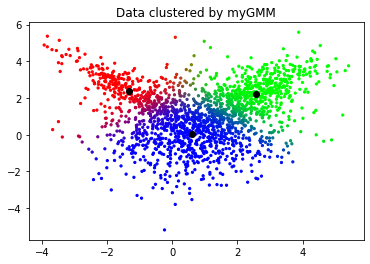

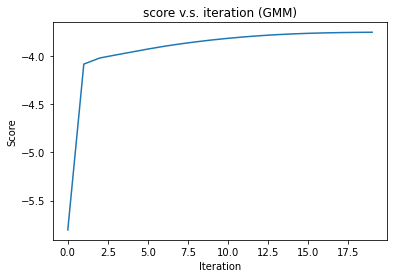

In [38]:
# Finding and plotting clusters
Mu, R, Pi, scores = myGMM(Xtrain, 3, 100)
plot_clusters(Xtrain, R, Mu)
plt.title("Data clustered by myGMM")

# Plotting score vs iterations
plt.figure()
plt.plot(range(20), scores[:20])
plt.title("score v.s. iteration (GMM)")
plt.xlabel("Iteration")
plt.ylabel("Score")

In [39]:
# Computing test and train scores
score_train = scoreGMM(Xtrain,Mu,Pi)
score_test = scoreGMM(Xtest,Mu,Pi)

# Printing
print("myGMM train score =", score_train)    
print("myGMM test score =", score_test)
print("Difference between myGMM and sklearn =", test_score_sph - score_test)

myGMM train score = -3.7466090254900184
myGMM test score = -3.813187804254466
Difference between myGMM and sklearn = 0.05208148440825511
